In [2]:
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress, TruncBondThresh  

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

## Funciones

In [3]:
# ============================================
# CONSTRUCCIÓN DEL TENSOR TRAIN DE TRANSICIÓN
# ============================================

"""
    build_transition_tensorchain(transition_rate, N, params)

Construye un TensorTrain que representa la matriz de transición A(σᵗ, σᵗ⁺¹).

Según la ecuación (4):
- A₁(σ₁ᵗ, σ₁ᵗ⁺¹) = (f₁(σ₁ᵗ, σ₁ᵗ⁺¹, ωⱼ))ⱼ∈[1,Q] · (Iᵣ ⊗ v_σ₁ᵗ)
- Aᵢ(σᵢᵗ, σᵢᵗ⁺¹) = (v_σᵢᵗᵀ ⊗ Iᵣ) · Fᵢ(σᵢᵗ, σᵢᵗ⁺¹) · (Iᵣ ⊗ v_σᵢᵗ)
- Aₙ(σₙᵗ, σₙᵗ⁺¹) = (v_σₙᵗᵀ ⊗ Iᵣ) · (fₙ(σₙᵗ, σₙᵗ⁺¹, ωⱼ))ⱼ∈[1,Q]

donde:
- Q = 2 (número de estados por espín)
- v_y = (δ(y,ω₁), ..., δ(y,ωᵣ)) es el vector delta
- Fᵢ es una matriz con las tasas de transición

# Argumentos
- `transition_rate`: Función (sigma_neighbors, sigma_new, i, params) → probabilidad
- `params`: Parámetros del modelo (j_vector, h_vector, beta)
- `N`: Número de sitios en la cadena
- `Q`: Cantidad de valores posibles de cada espin
- `σ`: Función que asigna a cada índice 1,2,...,Q el valor real del espín (for example (1,2) -> (-1,1))

# Retorna
- `TensorTrain`: Representación compacta de la matriz de transición
"""

function build_transition_tensorchain(transition_rate, params, Q = 2, σ = x -> 2x - 3)
    N = params.N  # Número de sitios en la cadena

    function delta_vector(spin_value)
        return [spin_value == σ(q) ? 1.0 : 0.0 for q in 1:Q]'
    end

    tensors = Array{Float64, 4}[]  # Vector de arrays 4D
    
    # ============================================
    # SITIO 1: A₁[1, Q², σ₁ᵗ, σ₁ᵗ⁺¹]
    # Forma: (f₁(σ₁ᵗ, σ₁ᵗ⁺¹, ωⱼ))ⱼ · (Iᵣ ⊗ v_σ₁ᵗ)
    # f₁ es un vector fila 1×Q
    # v_σ₁ᵗ es un vector fila 1×Q
    # (Iᵣ ⊗ v_σ₁ᵗ) es una matriz Q×Q²
    # Resultado: (1×Q) · (Q×Q²) = 1×Q²
    # ============================================
    A1 = zeros(1, Q^2, Q, Q)
    
    for sigma_t in 1:Q          # σ₁ᵗ
        for sigma_t_plus in 1:Q  # σ₁ᵗ⁺¹
            
            # Vector fila f₁(σ₁ᵗ, σ₁ᵗ⁺¹, ωⱼ) de dimensión 1×Q
            # ωⱼ representa los posibles valores de σ₂ᵗ
            f_vector = zeros(1, Q)
            for j in 1:Q
                omega_j = σ(j)  # Valor de σ₂ᵗ
                neighbors = [σ(sigma_t), omega_j]  # [σ₁ᵗ, σ₂ᵗ]
                f_vector[1, j] = transition_rate(neighbors, σ(sigma_t_plus), 1, params)
            end
            
            # v_σ₁ᵗ es un vector fila 1×Q
            v_sigma = delta_vector(σ(sigma_t))
            
            # (Iᵣ ⊗ v_σ₁ᵗ) es una matriz Q×Q²
            I_kron_v = kron(Matrix(I, Q, Q), v_sigma)  # Q×Q²
            
            # f₁ · (Iᵣ ⊗ v_σ₁ᵗ) = (1×Q) · (Q×Q²) = 1×Q²
            A1[1, :, sigma_t, sigma_t_plus] = f_vector * I_kron_v
        end
    end
    
    push!(tensors, A1)
    
    # ============================================
    # SITIOS INTERMEDIOS: Aᵢ[Q², Q², σᵢᵗ, σᵢᵗ⁺¹]
    # Forma: (v_σᵢᵗᵀ ⊗ Iᵣ) · Fᵢ(σᵢᵗ, σᵢᵗ⁺¹) · (Iᵣ ⊗ v_σᵢᵗ)
    # v_σᵢᵗ es un vector fila 1×Q, entonces v_σᵢᵗᵀ es un vector columna Q×1
    # (v_σᵢᵗᵀ ⊗ Iᵣ) es una matriz Q²×Q
    # Fᵢ es una matriz Q×Q
    # (Iᵣ ⊗ v_σᵢᵗ) es una matriz Q×Q²
    # Resultado: (Q²×Q) · (Q×Q) · (Q×Q²) = Q²×Q²
    # ============================================
    for i in 2:N-1
        Ai = zeros(Q^2, Q^2, Q, Q)
        
        for sigma_t in 1:Q         # σᵢᵗ
            for sigma_t_plus in 1:Q # σᵢᵗ⁺¹
                
                # Fᵢ(σᵢᵗ, σᵢᵗ⁺¹) es una matriz Q×Q
                # F_i[k,l] = fᵢ(ωₖ, σᵢᵗ, σᵢᵗ⁺¹, ωₗ)
                # donde ωₖ = σᵢ₋₁ᵗ y ωₗ = σᵢ₊₁ᵗ
                
                F_matrix = zeros(Q, Q)
                
                for k in 1:Q  # ωₖ = σᵢ₋₁ᵗ (vecino izquierdo)
                    for l in 1:Q  # ωₗ = σᵢ₊₁ᵗ (vecino derecho)
                        omega_k = σ(k)
                        omega_l = σ(l)
                        neighbors = [omega_k, σ(sigma_t), omega_l]  # [σᵢ₋₁ᵗ, σᵢᵗ, σᵢ₊₁ᵗ]
                        F_matrix[k, l] = transition_rate(neighbors, σ(sigma_t_plus), i, params)
                    end
                end
                
                # v_σᵢᵗ es un vector fila 1×Q
                v_sigma = delta_vector(σ(sigma_t))
                
                # v_σᵢᵗᵀ es un vector columna Q×1
                v_sigma_T = transpose(v_sigma)
                
                # (v_σᵢᵗᵀ ⊗ Iᵣ) es una matriz Q²×Q
                vT_kron_I = kron(v_sigma_T, Matrix(I, Q, Q))
                
                # (Iᵣ ⊗ v_σᵢᵗ) es una matriz Q×Q²
                I_kron_v = kron(Matrix(I, Q, Q), v_sigma)
                
                # Producto: (Q²×Q) · (Q×Q) · (Q×Q²) = Q²×Q²
                Ai[:, :, sigma_t, sigma_t_plus] = vT_kron_I * F_matrix * I_kron_v
            end
        end
        
        push!(tensors, Ai)
    end
    
    # ============================================
    # SITIO N: Aₙ[Q², 1, σₙᵗ, σₙᵗ⁺¹]
    # Forma: (v_σₙᵗᵀ ⊗ Iᵣ) · (fₙ(σₙᵗ, σₙᵗ⁺¹, ωⱼ))ⱼ
    # v_σₙᵗ es un vector fila 1×Q, entonces v_σₙᵗᵀ es un vector columna Q×1
    # (v_σₙᵗᵀ ⊗ Iᵣ) es una matriz Q²×Q
    # fₙ es un vector columna Q×1
    # Resultado: (Q²×Q) · (Q×1) = Q²×1
    # ============================================
    AN = zeros(Q^2, 1, Q, Q)
    
    for sigma_t in 1:Q         # σₙᵗ
        for sigma_t_plus in 1:Q # σₙᵗ⁺¹
            
            # Vector columna fₙ(σₙᵗ, σₙᵗ⁺¹, ωⱼ) de dimensión Q×1
            # ωⱼ representa los posibles valores de σₙ₋₁ᵗ
            f_vector = zeros(Q, 1)
            for j in 1:Q
                omega_j = σ(j)  # Valor de σₙ₋₁ᵗ
                neighbors = [omega_j, σ(sigma_t)]  # [σₙ₋₁ᵗ, σₙᵗ]
                f_vector[j, 1] = transition_rate(neighbors, σ(sigma_t_plus), N, params)
            end
            
            # v_σₙᵗ es un vector fila 1×Q
            v_sigma = delta_vector(σ(sigma_t))
            
            # v_σₙᵗᵀ es un vector columna Q×1
            v_sigma_T = transpose(v_sigma)
            
            # (v_σₙᵗᵀ ⊗ Iᵣ) es una matriz Q²×Q
            vT_kron_I = kron(v_sigma_T, Matrix(I, Q, Q))
            
            # (v_σₙᵗᵀ ⊗ Iᵣ) · fₙ = (Q²×Q) · (Q×1) = Q²×1
            AN[:, 1, sigma_t, sigma_t_plus] = vT_kron_I * f_vector
        end
    end
    
    push!(tensors, AN)
    
    # Crear y retornar el TensorTrain
    return TensorTrain(tensors)
end


build_transition_tensorchain (generic function with 3 methods)

In [4]:
# ============================================================================
# TENSOR TRAIN DE EVOLUCIÓN DE LA DISTRIBUCIÓN DE PROBABILIDAD
# ============================================================================

"""
    tensor_b_t(A, P0, t, max_bound) Evoluciona la distribución de probabilidad inicial P0 a través de t 
    pasos de tiempo usando la matriz de transición A en formato TensorTrain.
# Argumentos
- `A`: TensorTrain que representa la matriz de transición
- `P0`: Vector de vectores con la distribución de probabilidad inicial en cada sitio
- `t`: Número de pasos de tiempo a evolucionar
- `max_bound`: Límite máximo para la compresión del TensorTrain
"""
function tensor_b_t(A, P0, t, max_bound)
    N = length(A.tensors)               # Define N como la longitud de A.tensors

    # Construye el TensorTrain inicial para la distribución P0
    # Para cada sitio, crea un tensor de tamaño (1,1,Q) con las probabilidades iniciales.
    B = TensorTrain([(@tullio _[1,1,x] := pi[x]) for pi in P0])        

    # Itera sobre los pasos de tiempo, mostrando una barra de progreso.
    @showprogress for step in 1:t   

        # Para cada sitio, toma el tensor de transición Ai y el tensor de probabilidad Bi
        B = map(zip(A.tensors,B.tensors)) do (A_i, B_i)     
            
            # Realiza la suma sobre σ_t (el estado anterior), multiplicando el tensor de transición 
            # por la distribución. El resultado es un nuevo tensor para el siguiente tiempo.
            @tullio new_tensor_[m1,m2,n1,n2,sigma_t_plus] := A_i[m1,n1,sigma_t,sigma_t_plus] * B_i[m2,n2,sigma_t]

            # Reordena las dimensiones para que los bonds estén agrupados correctamente.
            @cast _[(m1,m2),(n1,n2),sigma_t_plus] := new_tensor_[m1,m2,n1,n2,sigma_t_plus]

        # Crea el nuevo TensorTrain con los tensores actualizados.
        end |> TensorTrain
        compress!(B; svd_trunc=TruncBond(max_bound)) 
        normalize!(B)
    end
    
    return B
end

tensor_b_t

In [48]:
# ============================================================================================
# TENSOR TRAIN DE EVOLUCIÓN DE LA DISTRIBUCIÓN DE PROBABILIDAD, COS SALVA PARA CADA T
# ============================================================================================

"""
    tensor_b_t(A, P0, t, max_bound) Evoluciona la distribución de probabilidad inicial P0 a través de t 
    pasos de tiempo usando la matriz de transición A en formato TensorTrain. Devuelve una lista con el 
    TensorTrain de la distribución en cada paso de tiempo.
# Argumentos
- `A`: TensorTrain que representa la matriz de transición
- `P0`: Vector de vectores con la distribución de probabilidad inicial en cada sitio
- `t`: Número de pasos de tiempo a evolucionar
- `max_bound`: Límite máximo para la compresión del TensorTrain
"""
function tensor_b_t_over_time(A, P0, t, max_bound)
    N = length(A.tensors)               # Define N como la longitud de A.tensors

    lista_B_T =[]

    # Construye el TensorTrain inicial para la distribución P0
    # Para cada sitio, crea un tensor de tamaño (1,1,Q) con las probabilidades iniciales.
    B = TensorTrain([(@tullio _[1,1,x] := pi[x]) for pi in P0])        
    push!(lista_B_T, B)
    # Itera sobre los pasos de tiempo, mostrando una barra de progreso.
    @showprogress for step in 1:t   

        # Para cada sitio, toma el tensor de transición Ai y el tensor de probabilidad Bi
        B = map(zip(A.tensors,B.tensors)) do (A_i, B_i)     
            
            # Realiza la suma sobre σ_t (el estado anterior), multiplicando el tensor de transición 
            # por la distribución. El resultado es un nuevo tensor para el siguiente tiempo.
            @tullio new_tensor_[m1,m2,n1,n2,sigma_t_plus] := A_i[m1,n1,sigma_t,sigma_t_plus] * B_i[m2,n2,sigma_t]

            # Reordena las dimensiones para que los bonds estén agrupados correctamente.
            @cast _[(m1,m2),(n1,n2),sigma_t_plus] := new_tensor_[m1,m2,n1,n2,sigma_t_plus]

        # Crea el nuevo TensorTrain con los tensores actualizados.
        end |> TensorTrain
        compress!(B; svd_trunc=TruncBond(max_bound)) 
        normalize!(B)
        push!(lista_B_T, B)
    end
    
    return lista_B_T
end

tensor_b_t_over_time

In [6]:
# ============================================
# FUNCIONES AUXILIARES
# ============================================

"""
σ(x) Mapea índice de espín a valor físico: 1 → -1, 2 → +1
"""
σ(x) = 2x - 3


# ============================================
# SELECCIÓN DE PARÁMETROS ALEATORIOS
# ============================================

"""
    random_params(N): Genera parámetros aleatorios para el modelo de Ising.
"""
function random_params(N)
    a, b = -1.0, 1.0
    params = (
        N = N, 
        beta = rand(),                              # Inversa de la temperatura (β = 1/kT)
        j_vector = a .+ (b - a) .* rand(N-1) ,        # Acoplamientos J_{i,i+1} (N-1 elementos)
        h_vector = a .+ (b - a) .* rand(N) ,    # Campos externos h_i (N elementos)
        p0 = rand(),                                 # Probabilidad de mantener configuración,
    )
    return params
end

"""
    random_params(N): Genera parámetros aleatorios para el modelo de Ising paralelo.
"""
function parallel_random_params(N)
    a, b = -1.0, 1.0
    params = (
        N = N, 
        beta_1 = rand(),                              # Inversa de la temperatura (β = 1/kT)
        beta_2 = rand(),                              # Inversa de la temperatura (β = 1/kT)
        j_vector = a .+ (b - a) .* rand(N-1) ,        # Acoplamientos J_{i,i+1} (N-1 elementos)
        h_vector = a .+ (b - a) .* rand(N) ,          # Campos externos h_i (N elementos)
        p0 = rand()                                   # Probabilidad de mantener configuración,
    )
    return params
end

"""
    random_P0(N, Q): Genera una distribución de probabilidad inicial aleatoria normalizada para N sitios 
    y Q estados por espín.
"""
function random_P0(N, Q = 2)
    P0 = [rand(Q) for _ in 1:N]
    for i in 1:N
        P0[i] /= sum(P0[i])  # Normaliza cada vector de probabilidad
    end
    return P0
end


"""
    parallel_random_P0_fixed(N): Genera una distribución de probabilidad inicial fija para N sitios 
    en el modelo paralelo.
"""
function parallel_random_P0_fixed(N)
    P0 = [Float64[rand(), 0.0, 0.0, rand()] for _ in 1:N]
    for i in 1:N
        P0[i] ./= sum(P0[i])  # Normaliza cada vector de probabilidad
    end
    return P0
end
    

parallel_random_P0_fixed

In [7]:
# ============================================
# TRABAJO CON TENSOR TRAINS
# ============================================

"""
* Multiplicación Kronecker de dos tensores en formato Tensor Train con dimensiones físicas coincidentes.
"""
function Base.:*(A::T, B::T) where T<:AbstractTensorTrain
    # Recorre los pares de tensores correspondientes de A y B (uno por cada sitio) usando zip. Para cada par (a, b), ejecuta el bloque siguiente y guarda el resultado en una nueva lista C.
    C = map(zip(A.tensors, B.tensors)) do (a, b)  # ← Usar zip explícitamente
        
        # Verifica que las dimensiones físicas (las últimas) de ambos tensores coincidan (por ejemplo, los índices de espín).
        @assert size(a)[3:end] == size(b)[3:end]

        # Colapsa todas las dimensiones físicas en una sola (de tamaño igual al producto de las dimensiones físicas), dejando los dos primeros ejes (bond dimensions) intactos.
        ar = reshape(a, size(a,1), size(a,2), prod(size(a)[3:end]))
        br = reshape(b, size(b,1), size(b,2), prod(size(b)[3:end]))
        
        # Usa el macro @cast (de TensorCast) para calcular el producto de Kronecker entre los bond dimensions de a y b y multiplica elemento a elemento la dimensión física. 
        # El resultado c tiene bond dimensions combinadas: (ia,ib) y (ja,jb), y la dimensión física x. 
        @cast c[(ia,ib),(ja,jb),x] := ar[ia,ja,x] * br[ib,jb,x]

        # Devuelve el tensor resultante con bond dimensions combinadas y las dimensiones físicas originales (descolapsadas).
        reshape(c, size(c,1), size(c,2), size(a)[3:end]...)
    end

    # Construye y retorna un nuevo TensorTrain (tipo T) usando los tensores C y multiplicando los factores escalares z de ambos operandos.
    T(C; z = A.z * B.z)
end


"""
    mult_sep(A, B): Multiplica dos TensorTrains A y B separando las dimensiones físicas.
"""
function mult_sep(A, B)
    d = map(zip(A.tensors,B.tensors)) do (a,b)
        @tullio c[m1,m2,n1,n2,x,y,x1,y1] := a[m1,n1,x,x1] * b[m2,n2,y,y1]
        @cast _[(m1,m2),(n1,n2),(x,y),(x1,y1)] := c[m1,m2,n1,n2,x,y,x1,y1]
    end
    return TensorTrain(d; z = A.z * B.z)   
end



mult_sep

In [43]:
# ============================================
# COMPROBACIONES Y DISTRIBUCIONES MARGINALES
# ============================================

"""
    sum_one_check(B): Verifica que la suma sobre todas las configuraciones de espines de la distribución 
    representada por el TensorTrain B sea 1.
"""
function sum_one_check(B)
    N = length(B.tensors)
    Q = size(B.tensors[1], 3)
    sum_tensor = fill(1.0, 1, 1)
    for i in 1:N
        Bi_sum = zeros(size(B.tensors[i], 1), size(B.tensors[i], 2))
        for q in 1:Q
            Bi_sum .+= B.tensors[i][:,:,q,1]
        end
        sum_tensor *= Bi_sum
    end
    return only(sum_tensor)
end

"""
    marginal_distribution(B, k): Calcula la distribución marginal P(σ_k) para el sitio k 
    a partir del TensorTrain B que representa la distribución conjunta.
"""
function marginal_distribution(B,k)
    N = length(B.tensors)
    K = size(B.tensors[1], 3)
    left_distribution = 1
    for i in 1:(k-1)
        Bi_sum = zeros(size(B.tensors[i], 1), size(B.tensors[i], 2))
        for q in 1:K
            Bi_sum .+= B.tensors[i][:,:,q,1]
        end
        left_distribution *= Bi_sum
    end
    right_distribution = 1
    for i in (k+1):N
        Bi_sum = zeros(size(B.tensors[i], 1), size(B.tensors[i], 2))
        for q in 1:K
            Bi_sum .+= B.tensors[i][:,:,q,1]
        end
        right_distribution *= Bi_sum
    end

    distribution = [(left_distribution * B.tensors[k][:,:, q, 1] * right_distribution)[1] for q in 1:K]
    return distribution
end

"""
    marginal_distribution_system(B): Calcula la distribución marginal P(σ_k) para todos los sitios k 
    a partir del TensorTrain B que representa la distribución conjunta.
"""

function marginal_distribution_system(B)
    N = length(B.tensors)
    distributions = []
    for k in 1:N
        push!(distributions, marginal_distribution(B, k))
    end
    return distributions
end

"""
    marginal_expected_value(B, k): Calcula el valor esperado marginal E[σ_k] para el sitio k 
    a partir del TensorTrain B que representa la distribución conjunta.
"""
function marginal_expected_value_simple(B, k)
    return  marginal_distribution(B, k)[1]*(-1) + marginal_distribution(B, k)[2]*(1)
end

"""
    marginal_expected_value(B, k): Calcula el valor esperado marginal E[σ_k^x], E[σ_k^y] para el sitio k 
    a partir del TensorTrain B que representa la distribución conjunta.
"""
function marginal_expected_value_parallel(B, k)
    function suma(a,b,B=B,k=k)
        return marginal_distribution(B, k)[a] + marginal_distribution(B, k)[b]
    end
    return  (suma(1,3)*(-1) + suma(2,4)*(1), suma(1,2)*(-1) + suma(3,4)*(1))
end

"""
    marginal_expected_value_system(B): Calcula el valor esperado marginal E[σ_k] para todos los sitios k 
    a partir del TensorTrain B que representa la distribución conjunta.
"""
function marginal_ev_system(B)
    N = length(B.tensors)
    expected_values = zeros(N)
    for k in 1:N
        expected_values[k] = marginal_expected_value(B, k)
    end
    return expected_values
end

"""
    marginal_expected_value_system(B): Calcula el valor esperado marginal E[σ_k] para todos los sitios k 
    a partir del TensorTrain B que representa la distribución conjunta.
"""
function marginal_ev_parallel_system(B)
    N = length(B.tensors)
    expected_values = []
    for k in 1:N
        push!(expected_values, marginal_expected_value_parallel(B, k))
    end
    return expected_values
end



"""
    covariance_between_chains(B)
Calcula la correlación entre las dos cadenas en cada sitio k:
Corr(σ_k^X, σ_k^Y) = E[σ_k^X σ_k^Y] - E[σ_k^X] E[σ_k^Y] 
"""

function covariance_between_chains(B)
    N = length(B.tensors)
    marginals = marginal_distribution_system(B)
    simple_ev = marginal_ev_parallel_system(B)
    correlations = [marginals[k][1]+marginals[k][4]-marginals[k][2]-marginals[k][3] - simple_ev[k][1]*simple_ev[k][2] for k in 1:N]
    return correlations
end

"""
    correlation_between_chains(B)
Calcula la correlación normalizada entre las dos cadenas en cada sitio k:
Corr(σ_k^X, σ_k^Y) = Cov(σ_k^X, σ_k^Y) / (sqrt(1 - E[σ_k^X]^2) * sqrt(1 - E[σ_k^Y]^2))
"""

function correlation_between_chains(B)
    N = length(B.tensors)
    simple_ev = marginal_ev_parallel_system(B)
    covariances = covariance_between_chains(B)
    correlations = [ covariances[k] / (sqrt(1 - simple_ev[k][1]^2) * sqrt(1 - simple_ev[k][2]^2))  for k in 1:N]
    return correlations
end

correlation_between_chains (generic function with 1 method)

In [9]:
# ============================================
# TASA DE TRANSICIÓN (Dinámica de Glauber)
# ============================================

"""
    transition_rate(sigma_neighbors, sigma_new, site_index, params)

Calcula la probabilidad de transición P(σᵢᵗ⁺¹ = sigma_new | configuración actual).

# Argumentos
- `sigma_neighbors`: Valores de espines vecinos relevantes
  * Sitio 1: [σ₁ᵗ, σ₂ᵗ]
  * Sitio i (intermedio): [σᵢ₋₁ᵗ, σᵢᵗ, σᵢ₊₁ᵗ]
  * Sitio N: [σₙ₋₁ᵗ, σₙᵗ]
- `sigma_new`: Nuevo valor del espín (±1)
- `site_index`: Índice del sitio (1 a N)
- `params`: Parámetros (beta, j_vector, h_vector)

# Retorna
- Probabilidad según dinámica de Glauber
"""
function transition_rate(sigma_neighbors, sigma_new, site_index, params)
    N = length(params.h_vector)
    
    if site_index == 1
        # Sitio 1: solo vecino derecho
        # sigma_neighbors = [σ₁ᵗ, σ₂ᵗ]
        h_eff = params.j_vector[1] * sigma_neighbors[2] + params.h_vector[1]
        
    elseif site_index == N
        # Sitio N: solo vecino izquierdo
        # sigma_neighbors = [σₙ₋₁ᵗ, σₙᵗ]
        h_eff = params.j_vector[end] * sigma_neighbors[1] + params.h_vector[end]
        
    else
        # Sitio intermedio: vecinos izquierdo y derecho
        # sigma_neighbors = [σᵢ₋₁ᵗ, σᵢᵗ, σᵢ₊₁ᵗ]
        h_eff = params.j_vector[site_index - 1] * sigma_neighbors[1] + 
                params.j_vector[site_index] * sigma_neighbors[3] + 
                params.h_vector[site_index]
    end
    
    # Dinámica de Glauber
    return (exp(params.beta * sigma_new * h_eff) / (2 * cosh(params.beta * h_eff)))*(1-params.p0) + params.p0* (sigma_new == sigma_neighbors[site_index == 1 ? 1 : site_index == N ? 2 : 2] ? 1.0 : 0.0)
end

transition_rate

In [10]:
# ============================================================
# TENSOR TRAIN DE TRANSICIÓN PARA TEMPERATURAS PARALELAS
# ============================================================

"""
    parallel_transition_tensorchain(transition_rate, N, params)

Construye un TensorTrain que representa la matriz de transición A((x,y)ᵗ, (x,y)ᵗ⁺¹).

# Argumentos
- `transition_rate`: Función (sigma_neighbors, sigma_new, i, params) → probabilidad
- `params`: Parámetros del modelo (j_vector, h_vector, beta_1, beta_2, N)
- `N`: Número de sitios en la cadena
- `Q`: Cantidad de valores posibles de cada espin
- `σ`: Función que asigna a cada índice 1,2,...,Q el valor real del espín (for example (1,2) -> (-1,1))

# Retorna
- `TensorTrain`: Representación compacta de la matriz de transición mixta
"""

function parallel_transition_tensor_train(transition_rate, params, Q = 2, σ = x -> 2x - 3)
    N = params.N
    params_1 = (N = N, beta = params.beta_1, j_vector = params.j_vector, h_vector = params.h_vector, p0 = params.p0)
    params_2 = (N = N, beta = params.beta_2, j_vector = params.j_vector, h_vector = params.h_vector, p0 = params.p0)
    A1 = build_transition_tensorchain(transition_rate, params_1, Q, σ)
    A2 = build_transition_tensorchain(transition_rate, params_2, Q, σ)
    return mult_sep(A1, A2) 
end

parallel_transition_tensor_train (generic function with 3 methods)

### MonteCarlo para Glauber

In [11]:
# ============================================
# ESTRUCTURA DE PARÁMETROS
# ============================================

"""
    GlauberParams

Parámetros del sistema de espines.

# Campos
- `beta::Float64`: Temperatura inversa (β = 1/kT)
- `j_vector::Vector{Float64}`: Acoplamientos J entre vecinos (longitud N-1)
- `h_vector::Vector{Float64}`: Campos magnéticos locales (longitud N)
- `p0::Float64`: Probabilidad de mantener el espín sin cambio
"""
struct GlauberParams
    beta::Float64
    j_vector::Vector{Float64}
    h_vector::Vector{Float64}
    p0::Float64
    
    function GlauberParams(beta, j_vector, h_vector, p0=0.0)
        @assert length(j_vector) == length(h_vector) - 1 "j_vector debe tener longitud N-1"
        @assert 0 <= p0 <= 1 "p0 debe estar en [0,1]"
        new(beta, j_vector, h_vector, p0)
    end
end

# ============================================
# TASA DE TRANSICIÓN (Dinámica de Glauber)
# ============================================

"""
    transition_rate(sigma_neighbors, sigma_new, site_index, params)

Calcula la probabilidad de transición P(σᵢᵗ⁺¹ = sigma_new | configuración actual).
"""
function transition_rate(sigma_neighbors, sigma_new, site_index, params)
    N = length(params.h_vector)
    
    if site_index == 1
        # Sitio 1: solo vecino derecho
        # sigma_neighbors = [σ₁ᵗ, σ₂ᵗ]
        h_eff = params.j_vector[1] * sigma_neighbors[2] + params.h_vector[1]
        sigma_current = sigma_neighbors[1]
        
    elseif site_index == N
        # Sitio N: solo vecino izquierdo
        # sigma_neighbors = [σₙ₋₁ᵗ, σₙᵗ]
        h_eff = params.j_vector[end] * sigma_neighbors[1] + params.h_vector[end]
        sigma_current = sigma_neighbors[2]
        
    else
        # Sitio intermedio: vecinos izquierdo y derecho
        # sigma_neighbors = [σᵢ₋₁ᵗ, σᵢᵗ, σᵢ₊₁ᵗ]
        h_eff = params.j_vector[site_index - 1] * sigma_neighbors[1] + 
                params.j_vector[site_index] * sigma_neighbors[3] + 
                params.h_vector[site_index]
        sigma_current = sigma_neighbors[2]
    end
    
    # Dinámica de Glauber con probabilidad p0 de no cambiar
    glauber_prob = exp(params.beta * sigma_new * h_eff) / (2 * cosh(params.beta * h_eff))
    
    # Agregar componente de mantener el estado
    if sigma_new == sigma_current
        return (1 - params.p0) * glauber_prob + params.p0
    else
        return (1 - params.p0) * glauber_prob
    end
end

# ============================================
# INICIALIZACIÓN
# ============================================

"""
    initialize_spins(N, initial_probs)

Inicializa la cadena de espines con distribución producto independiente.

# Argumentos
- `N::Int`: Número de sitios
- `initial_probs::Vector{Float64}`: Probabilidades p_i de que σᵢ = +1 (longitud N)

# Retorna
- Vector de espines iniciales (±1)
"""
function initialize_spins(N::Int, initial_probs::Vector{Float64})
    @assert length(initial_probs) == N "initial_probs debe tener longitud N"
    @assert all(0 .<= initial_probs .<= 1) "Probabilidades deben estar en [0,1]"
    
    spins = zeros(Int, N)
    for i in 1:N
        spins[i] = rand() < initial_probs[i] ? 1 : -1
    end
    return spins
end

"""
    initialize_spins_uniform(N, p_up=0.5)

Inicializa con probabilidad uniforme.
"""
function initialize_spins_uniform(N::Int, p_up::Float64=0.5)
    return initialize_spins(N, fill(p_up, N))
end

# ============================================
# PASO DE EVOLUCIÓN PARALELA
# ============================================

"""
    parallel_update!(spins_new, spins, params, rng)

Realiza un paso de actualización paralela (todos los espines simultáneamente).

# Argumentos
- `spins_new::Vector{Int}`: Vector para almacenar nueva configuración
- `spins::Vector{Int}`: Configuración actual
- `params::GlauberParams`: Parámetros del sistema
- `rng::AbstractRNG`: Generador de números aleatorios

# Modifica
- `spins_new` con la nueva configuración
"""
function parallel_update!(spins_new, spins, params, rng)
    N = length(spins)
    
    for i in 1:N
        # Preparar vecinos según la posición
        if i == 1
            sigma_neighbors = [spins[1], spins[2]]
        elseif i == N
            sigma_neighbors = [spins[N-1], spins[N]]
        else
            sigma_neighbors = [spins[i-1], spins[i], spins[i+1]]
        end
        
        # Calcular probabilidades para σᵢ = +1 y σᵢ = -1
        p_up = transition_rate(sigma_neighbors, 1, i, params)
        p_down = transition_rate(sigma_neighbors, -1, i, params)
        
        # Normalizar (por seguridad numérica)
        p_total = p_up + p_down
        p_up /= p_total
        
        # Muestrear nuevo estado
        spins_new[i] = rand(rng) < p_up ? 1 : -1
    end
end

# ============================================
# SIMULACIÓN MONTE CARLO
# ============================================

"""
    SimulationResult

Resultado de la simulación Monte Carlo.

# Campos
- `trajectories::Array{Int,2}`: Trayectorias (N_samples × N × T_steps)
- `magnetizations::Matrix{Float64}`: Magnetización promedio por sitio (N_samples × N)
- `correlations::Matrix{Float64}`: Correlaciones espaciales promedio
- `params::GlauberParams`: Parámetros usados
"""
struct SimulationResult
    trajectories::Array{Int,3}  # (N_samples, N, T_steps)
    magnetizations::Matrix{Float64}  # (N_samples, N)
    params::GlauberParams
end

"""
    run_monte_carlo(N, params, initial_probs, T_steps; 
                    N_samples=1000, seed=123, save_trajectory=true)

Ejecuta simulación Monte Carlo de la dinámica de Glauber paralela.

# Argumentos
- `N::Int`: Número de espines
- `params::GlauberParams`: Parámetros del sistema
- `initial_probs::Vector{Float64}`: Distribución inicial P₀
- `T_steps::Int`: Número de pasos temporales

# Argumentos opcionales
- `N_samples::Int=1000`: Número de realizaciones independientes
- `seed::Int=123`: Semilla para reproducibilidad
- `save_trajectory::Bool=true`: Si guardar trayectorias completas

# Retorna
- `SimulationResult` con resultados de la simulación
"""
function run_monte_carlo(N::Int, params::GlauberParams, initial_probs::Vector{Float64}, 
                        T_steps::Int; N_samples::Int=1000, seed::Int=123, 
                        save_trajectory::Bool=true)
    
    rng = MersenneTwister(seed)
    
    # Almacenamiento
    if save_trajectory
        trajectories = zeros(Int, N_samples, N, T_steps + 1)
    else
        trajectories = zeros(Int, 0, 0, 0)
    end
    magnetizations = zeros(Float64, N_samples, N)
    
    # Buffers para eficiencia
    spins = zeros(Int, N)
    spins_new = zeros(Int, N)
    
    # Simulación
    for sample in 1:N_samples
        # Inicializar
        spins .= initialize_spins(N, initial_probs)
        
        if save_trajectory
            trajectories[sample, :, 1] .= spins
        end
        
        # Evolución temporal
        for t in 1:T_steps
            parallel_update!(spins_new, spins, params, rng)
            spins, spins_new = spins_new, spins  # Swap eficiente
            
            if save_trajectory
                trajectories[sample, :, t+1] .= spins
            end
        end
        
        # Guardar magnetización final
        magnetizations[sample, :] .= spins
    end
    
    return SimulationResult(trajectories, magnetizations, params)
end

# ============================================
# ANÁLISIS Y OBSERVABLES
# ============================================

"""
    compute_magnetization(result)

Calcula magnetización promedio por sitio.
"""
function compute_magnetization(result::SimulationResult)
    return mean(result.magnetizations, dims=1)[1, :]
end

"""
    compute_magnetization_error(result)

Calcula error estándar de la magnetización.
"""
function compute_magnetization_error(result::SimulationResult)
    return std(result.magnetizations, dims=1)[1, :] / sqrt(size(result.magnetizations, 1))
end

"""
    compute_correlation(result, i, j)

Calcula ⟨σᵢ σⱼ⟩ promedio sobre realizaciones.
"""
function compute_correlation(result::SimulationResult, i::Int, j::Int)
    return mean(result.magnetizations[:, i] .* result.magnetizations[:, j])
end



"""
    compute_trajectory_magnetization(result, sample)

Calcula evolución temporal de magnetización total para una muestra.
"""

function compute_trajectory_magnetization(result::SimulationResult, sample::Int)
    T = size(result.trajectories, 3)
    N = size(result.trajectories, 2)
    mag = zeros(T)
    for t in 1:T
        mag[t] = sum(result.trajectories[sample, :, t]) / N
    end
    return mag
end


compute_trajectory_magnetization (generic function with 1 method)

In [12]:
# ============================================
# ESTRUCTURA DE PARÁMETROS
# ============================================

"""
    GlauberParams

Parámetros del sistema de espines.

# Campos
- `beta::Float64`: Temperatura inversa (β = 1/kT)
- `j_vector::Vector{Float64}`: Acoplamientos J entre vecinos (longitud N-1)
- `h_vector::Vector{Float64}`: Campos magnéticos locales (longitud N)
- `p0::Float64`: Probabilidad de mantener el espín sin cambio
"""
struct GlauberParamsParallel
    beta_1::Float64
    beta_2::Float64
    j_vector::Vector{Float64}
    h_vector::Vector{Float64}
    p0::Float64
    
    function GlauberParamsParallel(beta_1, beta_2, j_vector, h_vector, p0=0.0)
        @assert length(j_vector) == length(h_vector) - 1 "j_vector debe tener longitud N-1"
        @assert 0 <= p0 <= 1 "p0 debe estar en [0,1]"
        new(beta_1, beta_2, j_vector, h_vector, p0)
    end
end

# ============================================
# TASA DE TRANSICIÓN (Dinámica de Glauber)
# ============================================

"""
    transition_rate(sigma_neighbors, sigma_new, site_index, params)

Calcula la probabilidad de transición P(σᵢᵗ⁺¹ = sigma_new | configuración actual).
"""
function transition_rate(sigma_neighbors, sigma_new, site_index, params)
    N = length(params.h_vector)
    
    if site_index == 1
        # Sitio 1: solo vecino derecho
        # sigma_neighbors = [σ₁ᵗ, σ₂ᵗ]
        h_eff = params.j_vector[1] * sigma_neighbors[2] + params.h_vector[1]
        sigma_current = sigma_neighbors[1]
        
    elseif site_index == N
        # Sitio N: solo vecino izquierdo
        # sigma_neighbors = [σₙ₋₁ᵗ, σₙᵗ]
        h_eff = params.j_vector[end] * sigma_neighbors[1] + params.h_vector[end]
        sigma_current = sigma_neighbors[2]
        
    else
        # Sitio intermedio: vecinos izquierdo y derecho
        # sigma_neighbors = [σᵢ₋₁ᵗ, σᵢᵗ, σᵢ₊₁ᵗ]
        h_eff = params.j_vector[site_index - 1] * sigma_neighbors[1] + 
                params.j_vector[site_index] * sigma_neighbors[3] + 
                params.h_vector[site_index]
        sigma_current = sigma_neighbors[2]
    end
    
    # Dinámica de Glauber con probabilidad p0 de no cambiar
    glauber_prob = exp(params.beta * sigma_new * h_eff) / (2 * cosh(params.beta * h_eff))
    
    # Agregar componente de mantener el estado
    if sigma_new == sigma_current
        return (1 - params.p0) * glauber_prob + params.p0
    else
        return (1 - params.p0) * glauber_prob
    end
end

# ============================================
# INICIALIZACIÓN
# ============================================

"""
    initialize_spins(N, initial_probs)

Inicializa la cadena de espines con distribución producto independiente.

# Argumentos
- `N::Int`: Número de sitios
- `initial_probs::Vector{Float64}`: Probabilidades p_i de que σᵢ = +1 (longitud N)

# Retorna
- Vector de espines iniciales (±1)
"""
function initialize_spins(N::Int, initial_probs::Vector{Float64})
    @assert length(initial_probs) == N "initial_probs debe tener longitud N"
    @assert all(0 .<= initial_probs .<= 1) "Probabilidades deben estar en [0,1]"
    
    spins = zeros(Int, N)
    for i in 1:N
        spins[i] = rand() < initial_probs[i] ? 1 : -1
    end
    return spins
end

# ============================================
# PASO DE EVOLUCIÓN PARALELA
# ============================================

"""
    parallel_update!(spins_new, spins, params, rng)

Realiza un paso de actualización paralela (todos los espines simultáneamente).

# Argumentos
- `spins_new::Vector{Int}`: Vector para almacenar nueva configuración
- `spins::Vector{Int}`: Configuración actual
- `params::GlauberParams`: Parámetros del sistema
- `rng::AbstractRNG`: Generador de números aleatorios

# Modifica
- `spins_new` con la nueva configuración
"""
function parallel_update!(spins_new, spins, params, rng)
    N = length(spins)
    
    for i in 1:N
        # Preparar vecinos según la posición
        if i == 1
            sigma_neighbors = [spins[1], spins[2]]
        elseif i == N
            sigma_neighbors = [spins[N-1], spins[N]]
        else
            sigma_neighbors = [spins[i-1], spins[i], spins[i+1]]
        end
        
        # Calcular probabilidades para σᵢ = +1 y σᵢ = -1
        p_up = transition_rate(sigma_neighbors, 1, i, params)
        p_down = transition_rate(sigma_neighbors, -1, i, params)
        
        # Normalizar (por seguridad numérica)
        p_total = p_up + p_down
        p_up /= p_total
        
        # Muestrear nuevo estado
        spins_new[i] = rand(rng) < p_up ? 1 : -1
    end
end

# ============================================
# SIMULACIÓN MONTE CARLO
# ============================================

"""
    SimulationResult

Resultado de la simulación Monte Carlo.

# Campos
- `trajectories::Array{Int,2}`: Trayectorias (N_samples × N × T_steps)
- `magnetizations::Matrix{Float64}`: Magnetización promedio por sitio (N_samples × N)
- `correlations::Matrix{Float64}`: Correlaciones espaciales promedio
- `params::GlauberParams`: Parámetros usados
"""
struct SimulationResultParallel
    trajectories_x::Array{Int,3}  # (N_samples, N, T_steps)
    trajectories_y::Array{Int,3}  # (N_samples, N, T_steps)
    magnetizations_x::Matrix{Float64}  # (N_samples, N)
    magnetizations_y::Matrix{Float64}  # (N_samples, N)
    params::GlauberParamsParallel
end

"""
    run_monte_carlo(N, params, initial_probs, T_steps; 
                    N_samples=1000, seed=123, save_trajectory=true)

Ejecuta simulación Monte Carlo de la dinámica de Glauber paralela.

# Argumentos
- `N::Int`: Número de espines
- `params::GlauberParams`: Parámetros del sistema
- `initial_probs::Vector{Float64}`: Distribución inicial P₀
- `T_steps::Int`: Número de pasos temporales

# Argumentos opcionales
- `N_samples::Int=1000`: Número de realizaciones independientes
- `seed::Int=123`: Semilla para reproducibilidad
- `save_trajectory::Bool=true`: Si guardar trayectorias completas

# Retorna
- `SimulationResult` con resultados de la simulación
"""
function run_parallel_monte_carlo(N::Int, params::GlauberParamsParallel, initial_probs::Vector{Float64}, 
                        T_steps::Int; N_samples::Int=1000, seed::Int=123, 
                        save_trajectory::Bool=true)
    
    rng = MersenneTwister(seed)
    
    params_1 = (N = N, beta = params.beta_1, j_vector = params.j_vector, h_vector = params.h_vector, p0 = params.p0)
    params_2 = (N = N, beta = params.beta_2, j_vector = params.j_vector, h_vector = params.h_vector, p0 = params.p0)
    
    # Almacenamiento
    if save_trajectory
        trajectories_x = zeros(Int, N_samples, N, T_steps + 1)
        trajectories_y = zeros(Int, N_samples, N, T_steps + 1)
    else
        trajectories_x = zeros(Int, 0, 0, 0)
        trajectories_y = zeros(Int, 0, 0, 0)
    end
    magnetizations_x = zeros(Float64, N_samples, N)
    magnetizations_y = zeros(Float64, N_samples, N)
    
    # Buffers para eficiencia
    spins_x = zeros(Int, N)
    spins_new_x = zeros(Int, N)
    
    spins_y = zeros(Int, N)
    spins_new_y = zeros(Int, N)

    # Simulación
    for sample in 1:N_samples
        # Inicializar
        spins_x .= initialize_spins(N, initial_probs)
        spins_y .= spins_x  # Misma configuración inicial para ambos sistemas
        
        if save_trajectory
            trajectories_x[sample, :, 1] .= spins_x
            trajectories_y[sample, :, 1] .= spins_y
        end
        
        # Evolución temporal
        for t in 1:T_steps
            parallel_update!(spins_new_x, spins_x, params_1, rng)
            parallel_update!(spins_new_y, spins_y, params_2, rng)
            spins_x, spins_new_x = spins_new_x, spins_x  # Swap eficiente
            spins_y, spins_new_y = spins_new_y, spins_y  # Swap eficiente
            
            if save_trajectory
                trajectories_x[sample, :, t+1] .= spins_x  
            end

            if save_trajectory
                trajectories_y[sample, :, t+1] .= spins_y 
            end
        end
        
        # Guardar magnetización final
        magnetizations_x[sample, :] .= spins_x
        magnetizations_y[sample, :] .= spins_y
    end
    
    return SimulationResultParallel(trajectories_x, trajectories_y, magnetizations_x, magnetizations_y, params)
end




run_parallel_monte_carlo

In [13]:
# ============================================
# ANÁLISIS Y OBSERVABLES
# ============================================

"""
    compute_magnetization(result)

Calcula magnetización promedio por sitio.
"""
function compute_magnetization_parallel(result::SimulationResultParallel)
    return mean(result.magnetizations_x, dims=1)[1, :], mean(result.magnetizations_y, dims=1)[1, :]
end

"""
    compute_magnetization_error(result)

Calcula error estándar de la magnetización.
"""
function compute_magnetization_error_parallel(result::SimulationResultParallel)
    return std(result.magnetizations_x, dims=1)[1, :] / sqrt(size(result.magnetizations_x, 1)), std(result.magnetizations_y, dims=1)[1, :] / sqrt(size(result.magnetizations_y, 1))
end

"""
    compute_correlation(result, i, j)

Calcula ⟨σᵢ σⱼ⟩ promedio sobre realizaciones.
"""
function compute_correlation_parallel(result::SimulationResultParallel, i::Int, j::Int)
    return mean(result.magnetizations_x[:, i] .* result.magnetizations_x[:, j]), mean(result.magnetizations_y[:, i] .* result.magnetizations_y[:, j])
end

"""
    compute_marginal_magnetization_parallel(result)

Devuelve la magnetización marginal de cada espín en cada instante de tiempo, para ambos sistemas.
Retorna dos matrices: (mag_x, mag_y) de tamaño (N_x, T_x) y (N_y, T_y).
"""
function compute_marginal_magnetization_parallel(result)
    N_samples = size(result.trajectories_x, 1)
    N_x = size(result.trajectories_x, 2)
    T_x = size(result.trajectories_x, 3)
    N_y = size(result.trajectories_y, 2)
    T_y = size(result.trajectories_y, 3)
    mag_x = zeros(N_x, T_x)
    mag_y = zeros(N_y, T_y)
    for t in 1:T_x
        for i in 1:N_x
            mag_x[i, t] = mean(result.trajectories_x[sample, i, t] for sample in 1:N_samples)
        end
    end
    for t in 1:T_y
        for i in 1:N_y
            mag_y[i, t] = mean(result.trajectories_y[sample, i, t] for sample in 1:N_samples)
        end
    end
    return mag_x, mag_y
end


compute_marginal_magnetization_parallel

In [14]:
"""
    plot_two_sextuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)

Grafica dos series temporales de vectores por sitio:
- `times`: vector de tiempos (length T)
- `Sdots`: datos para graficar como puntos — forma N×T o T×N
- `Slines`: datos para graficar como líneas — forma N×T o T×N

Cada fila i corresponde al sitio i. Si la entrada viene en orientación time×sites,
la función la transpone automáticamente.

Opciones:
- `site_labels`: vector de etiquetas para leyenda (por defecto "Sitio 1", ...).
- `savepath`: si no es `nothing` guarda la figura en ese archivo (PNG, PDF, ...).
"""
function plot_two_Ntuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)
    # Normalizar formatos: queremos N × T
    if size(Sdots,1) == length(times) && size(Sdots,2) != length(times)
        Sdots = permutedims(Sdots)   # T×N -> N×T
    end
    if size(Slines,1) == length(times) && size(Slines,2) != length(times)
        Slines = permutedims(Slines)
    end

    @assert size(Sdots) == size(Slines) "Sdots y Slines deben tener la misma forma"
    N, T = size(Sdots)
    @assert length(times) == T "length(times) debe coincidir con número de columnas en Sdots/Slines"

    # Etiquetas por sitio
    if site_labels === nothing
        site_labels = ["Sitio $i" for i in 1:N]
    else
        @assert length(site_labels) == N "site_labels debe tener longitud N"
    end

    cols = distinguishable_colors(N)  # paleta con N colores distinguibles

    p = plot(title="Marginal expectation per spin over steps",
             xlabel="Tiempo", ylabel="Valor",
             legend=:outerright, grid=true, size=(900,500))

    # Dibujar: línea para Slines (con label) y puntos para Sdots (sin duplicar labels)
    for i in 1:N
        plot!(p, times, Slines[i, :],
              color=cols[i], linewidth=2, label=site_labels[i])
        scatter!(p, times, Sdots[i, :],
                 color=cols[i], marker=:circle, markersize=4, label=false)
    end

    if savepath !== nothing
        savefig(p, savepath)
    end

    return p
end

plot_two_Ntuples

## Pruebas

In [15]:
N = 50
t = 100
max_bound = 5

# TensotTrain de transición simpmle
A = build_transition_tensorchain(transition_rate, random_params(N))
# TensorTrain de probabilidad tiempo t simple
B_t = tensor_b_t(A, random_P0(N), t, max_bound)

# TensorTrain de transición paralela
A_plus = parallel_transition_tensor_train(transition_rate, parallel_random_params(N))

# TensorTrain de probabilidad tiempo t paralela con cadenas independientes
B_t_plus = tensor_b_t(A_plus, random_P0(N, 4), t, max_bound)

# TensorTrain de probabilidad tiempo t paralela con condiciones iniciales fijas
B_t_plus_fixed = tensor_b_t(A_plus, parallel_random_P0_fixed(N), t, max_bound)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[0.452377051236553 0.33350542644784953 -0.13281540783321805 0.09791729809783205;;; 0.1328171301787001 0.09791496186291805 0.4523757837195095 -0.3335071457389805;;; 0.33350494741198783 -0.45237658383197843 -0.09791892971554951 -0.13281699980018385;;; 0.09791659347458512 -0.13281872215186694 0.33350666669489726 0.45237531632336137], [0.5090257782790991 0.2651412341701339 … 0.041535829877617676 -0.008660868369663911; 0.05419731829252391 0.0512738700910432 … 0.00802968464821871 0.00023345304678663666; -0.007479564039596878 -0.0038969597918286558 … -0.018261852171561753 -0.4429773499914539; 0.0007964117795665016 0.0007536243983529073 … 0.003534867081324866 0.04721417462211983;;; 0.04750091017551965 0.024739878264510424 … -0.14255511718539063 -0.20765895334549345; 0.005057257308659449 0.004784415886891993 … -0.02757036423358133 -0.022227265601443752; 0.06507458448437344 0.03389246018731001 … -0.222932654533504 0.16750262926602238; -0.00

In [16]:
println("Suma total de B_t: ", sum_one_check(B_t),"\n")
println("Suma total de B_t_plus: ", sum_one_check(B_t_plus),"\n")
println("Suma total de B_t_plus_fixed: ", sum_one_check(B_t_plus_fixed),"\n")
println("Distribución marginal en el sitio 10 de B_t: ", marginal_distribution(B_t, 10),"\n")
println("Distribución marginal en el sitio 10 de B_t_plus: ", marginal_distribution(B_t_plus, 10),"\n")
println("Distribución marginal en el sitio 10 de B_t_plus_fixed: ", marginal_distribution(B_t_plus_fixed, 10),"\n")
println("Valor esperado marginal en el sitio 10 de B_t: ", marginal_expected_value_simple(B_t, 10),"\n")
println("Valor esperado marginal en el sitio 10 de B_t_plus: ", marginal_expected_value_parallel(B_t_plus, 10),"\n")
println("Valor esperado marginal en el sitio 10 de B_t_plus_fixed: ", marginal_expected_value_parallel(B_t_plus_fixed, 10),"\n")


Suma total de B_t: 0.9999999999999963

Suma total de B_t_plus: 1.0000000000000007

Suma total de B_t_plus_fixed: 1.0000000000000024

Distribución marginal en el sitio 10 de B_t: [0.5660158974207156, 0.43398410257928116]

Distribución marginal en el sitio 10 de B_t_plus: [0.33316755336544074, 0.22477195067846512, 0.2639722177920945, 0.17808827816400233]

Distribución marginal en el sitio 10 de B_t_plus_fixed: [0.3331649496126432, 0.22477456023232226, 0.2639701485476437, 0.1780903416073931]

Valor esperado marginal en el sitio 10 de B_t: -0.1320317948414344

Valor esperado marginal en el sitio 10 de B_t_plus: (-0.19427954231506783, -0.11587900808780904)

Valor esperado marginal en el sitio 10 de B_t_plus_fixed: (-0.19427019632057163, -0.11587901968992864)



In [81]:
N = 20                                  # Número de espines
T = 100                                 # Número de iteraciones (tiempo)
params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0
P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallel( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0)
result_mc = run_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 10000, seed = 42)

mag_mc_time = compute_marginal_magnetization_parallel(result_mc)   # magnetización de cada espín por instante de tiempo

# TensorTrains
max_bound = 5

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_plus_fixed = tensor_b_t_over_time(A_plus, P0, T, max_bound)

mag_tt_time = [marginal_ev_parallel_system(B_t_plus_fixed[k]) for k in 1:T]

print("done")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


done

In [ ]:
# params = (
#     N = 10,
#     beta_1 = 0.5,
#     beta_2 = 1.0,
#     j_vector = randn(N-1),
#     h_vector = randn(N),
#     p0 = 0.1
# )

In [82]:
print(params)

(N = 20, beta_1 = 0.021260522458365738, beta_2 = 0.5331004216059388, j_vector = [0.017023106655990494, 0.646958312298956, -0.9751732421532247, -0.9812709330693425, -0.016445033935114983, 0.5175159031764758, 0.14522554263310616, -0.22506050921486165, -0.6391298908586995, 0.9569028324548778, -0.26744996766236184, 0.8219759772665267, -0.2990422785655349, -0.025637559725318004, 0.422370766132419, -0.4115949318695489, -0.8571816772379643, -0.8353877645294527, -0.21139864256111962], h_vector = [-0.19508831769468693, 0.8308592084472375, -0.05347714256040148, -0.5928893727538826, 0.005781080913496162, -0.30159545453909975, -0.9396348209058123, 0.05452476804186568, -0.6581195979139374, -0.05476833536299419, 0.9327590524052101, 0.13705639407874282, -0.5028167820497269, 0.866820897363094, -0.5206595141116139, 0.25818312615931416, -0.6155884870110147, -0.9994791214381462, 0.057806331430640956, 0.11740081086309773], p0 = 0.3371168578810835)

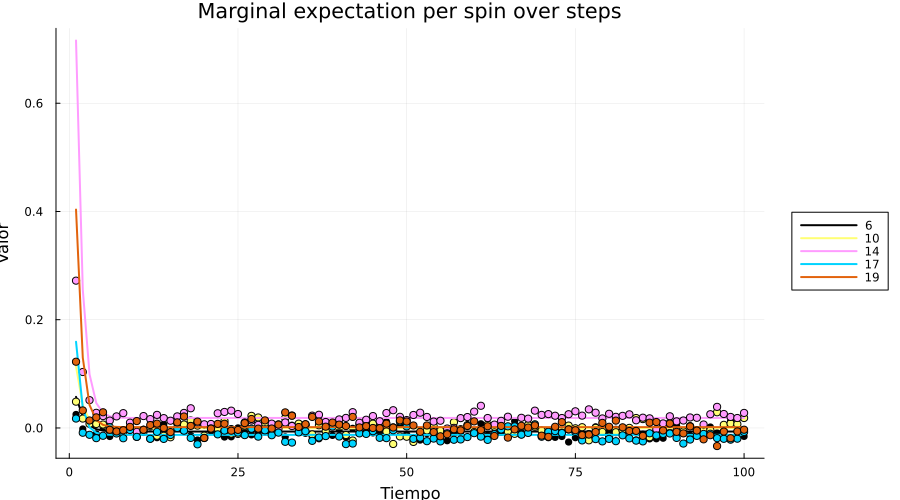

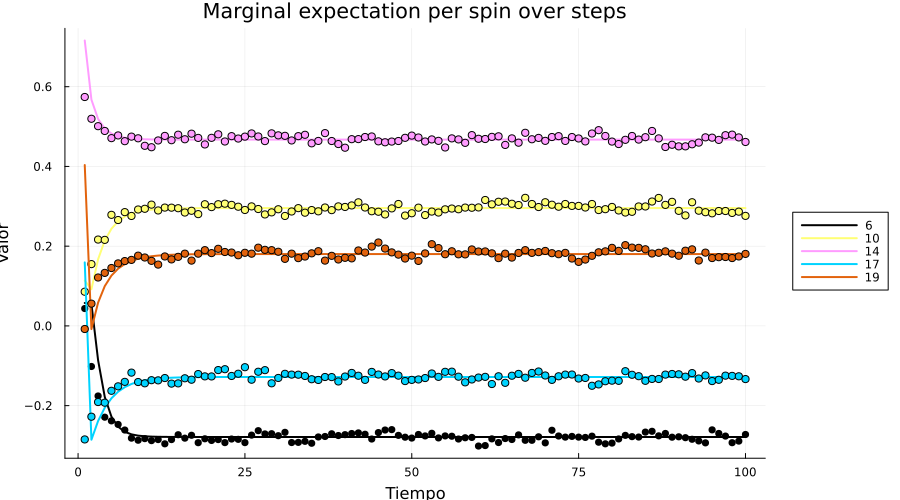

In [83]:
numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

for system in 1:2
    Sdots = mag_mc_time[system][lista_of_spins, 2:T+1] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end

In [92]:
system_of_correlations = []
for t in 1:10
    push!(system_of_correlations, correlation_between_chains(B_t_plus_fixed[t]))
end

print(correlation_between_chains(B_t_plus_fixed[1]), "\n", covariance_between_chains(B_t_plus_fixed[1]), "\n")

[0.9999999999999998, 0.9999999999999999, 0.9999999999999993, 0.9999999999999993, 0.9999999999999997, 0.9999999999999999, 0.9999999999999998, 0.9999999999999998, 0.9999999999999997, 0.9999999999999999, 0.9999999999999998, 0.9999999999999994, 0.9999999999999999, 0.9999999999999999, 0.9999999999999998, 0.9999999999999998, 0.9999999999999999, 0.9999999999999997, 0.9999999999999998, 0.9999999999999998]
[0.9477682570825443, 0.9920203220032507, 0.19992095497443718, 0.26677478114342645, 0.9764103641083295, 0.996693120541898, 0.4167493614429212, 0.9533317993694901, 0.4907418935047232, 0.9870830580192431, 0.9625921778092977, 0.5619488182789425, 0.729333020770633, 0.487476338592451, 0.9667372470559841, 0.9036961809351809, 0.9746172428606888, 0.6980423858402689, 0.8371296936758975, 0.9732793644659623]


In [98]:
system_of_correlations

10-element Vector{Any}:
 [0.9999999999999998, 0.9999999999999999, 0.9999999999999993, 0.9999999999999993, 0.9999999999999997, 0.9999999999999999, 0.9999999999999998, 0.9999999999999998, 0.9999999999999997, 0.9999999999999999, 0.9999999999999998, 0.9999999999999994, 0.9999999999999999, 0.9999999999999999, 0.9999999999999998, 0.9999999999999998, 0.9999999999999999, 0.9999999999999997, 0.9999999999999998, 0.9999999999999998]
 [0.1080148262459109, 0.11329428854221671, 0.026631040333684585, 0.037098407723036034, 0.11510412645572597, 0.11400017600159669, 0.04999381008400928, 0.10885160589365851, 0.0667019658448869, 0.11727491140938967, 0.11661525118194364, 0.07163872122147104, 0.10234032846755504, 0.06993257926116388, 0.11305015698340286, 0.10591920489011193, 0.11831594397614277, 0.08584320560699932, 0.09840963488987756, 0.1112105705393011]
 [0.012275183458425853, 0.017263736412300265, 0.00619162374234373, 0.010619044258309571, 0.02405554774957026, 0.015943948924608344, 0.007487050215884277,

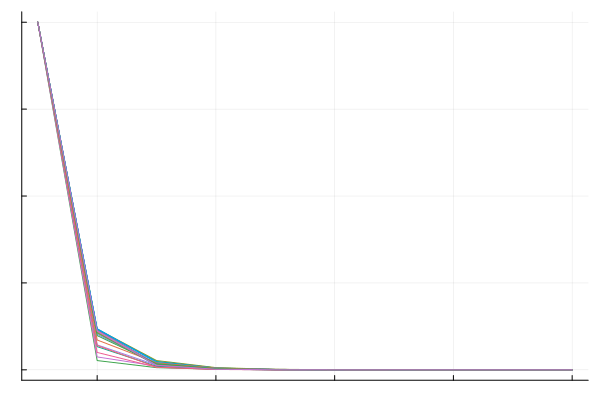

In [ ]:
using Plots

# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
# , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición"
plot(mat')

In [102]:
mat[1,:]

10-element Vector{Float64}:
 0.9999999999999998
 0.1080148262459109
 0.012275183458425853
 0.001398178342083299
 0.00015917443989003818
 1.8124206444819513e-5
 2.065671835630497e-6
 2.359247593785038e-7
 2.7061976643216293e-8
 3.13156667112866e-9

### Some index references

    ( X  Y)

1-  (-1 -1)

2-  ( 1 -1)

3-  (-1  1)

4-  ( 1  1)

mag_tt_time[time][spin][X-Y]

mag_mc_time[X-Y][spin,time]

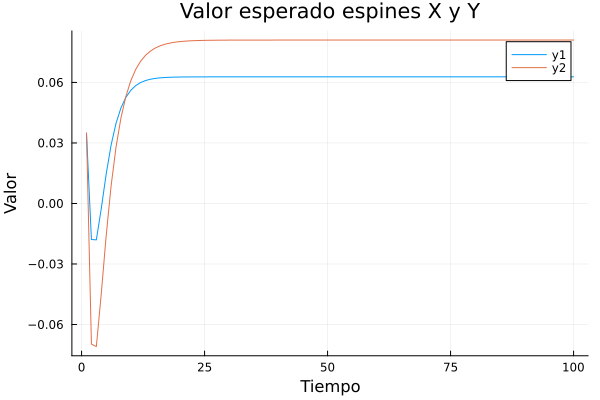

In [80]:
spin_X_ev_time = []
spin_Y_ev_time = []
spin_number = 2
for t in 1:100
    evs_X = mag_tt_time[t][spin_number][1]  # Valor esperado del espín X en el tiempo t
    evs_Y = mag_tt_time[t][spin_number][2]  # Valor esperado del espín Y en el tiempo t
    push!(spin_X_ev_time, evs_X)
    push!(spin_Y_ev_time, evs_Y)
end
mat_ev = hcat(spin_X_ev_time, spin_Y_ev_time)'  # Convierte a matriz 2 x T
plot(mat_ev', legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Valor esperado espines X y Y")  